# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 50 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 50, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 50, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 50, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(50, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(50, (5, 1), activation='tanh', input_shape=(50, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(12, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(9, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001), padding = 'same'))

#Cuarta capa convolucional
model.add(Conv2D(50, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(50, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))



In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 10, 50)        550       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 10, 50)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 10, 12)        3012      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 10, 12)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 10, 9)          549       
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 9, 50)         

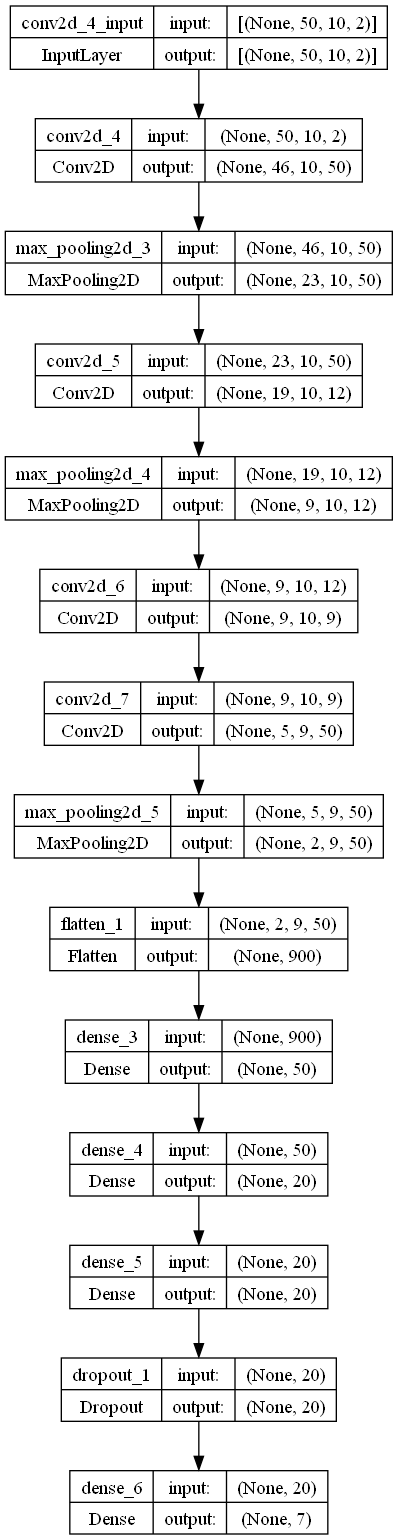

In [24]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [27]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 3s 4ms/step - loss: 10.0751 - mae: 2.3630 - val_loss: 8.0706 - val_mae: 2.1100 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 3s 4ms/step - loss: 8.2925 - mae: 2.1806 - val_loss: 7.2435 - val_mae: 2.0377 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 3s 4ms/step - loss: 7.6704 - mae: 2.1284 - val_loss: 6.8525 - val_mae: 1.9867 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 3s 4ms/step - loss: 7.3300 - mae: 2.0786 - val_loss: 6.6371 - val_mae: 1.9543 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 3s 4ms/step - loss: 6.9622 - mae: 2.0028 - val_loss: 6.2616 - val_mae: 1.8792 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 3s 4ms/step - loss: 6.5776 - mae: 1.9207 - val_loss: 5.6949 - val_mae: 1.7239 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 3s 4ms/step - loss: 6.2573 - mae: 1.8577 - val_loss: 5.5288 -

700/700 [==============================] - 3s 4ms/step - loss: 4.6614 - mae: 1.5519 - val_loss: 4.0613 - val_mae: 1.4111 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.6317 - mae: 1.5491 - val_loss: 4.2210 - val_mae: 1.4463 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.6156 - mae: 1.5423 - val_loss: 4.0800 - val_mae: 1.4036 - lr: 0.0010
Epoch 59/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.6112 - mae: 1.5395 - val_loss: 4.0557 - val_mae: 1.4050 - lr: 0.0010
Epoch 60/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.6182 - mae: 1.5425 - val_loss: 4.1709 - val_mae: 1.4291 - lr: 0.0010
Epoch 61/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.6229 - mae: 1.5429 - val_loss: 4.1105 - val_mae: 1.4039 - lr: 0.0010
Epoch 62/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.6073 - mae: 1.5388 - val_loss: 4.1331 - val_mae

700/700 [==============================] - 3s 4ms/step - loss: 4.3647 - mae: 1.4744 - val_loss: 4.0178 - val_mae: 1.3700 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.3780 - mae: 1.4724 - val_loss: 4.0698 - val_mae: 1.3831 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.4006 - mae: 1.4798 - val_loss: 4.0517 - val_mae: 1.3780 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.4281 - mae: 1.4826 - val_loss: 3.9580 - val_mae: 1.3499 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.3993 - mae: 1.4785 - val_loss: 4.1499 - val_mae: 1.3948 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.3756 - mae: 1.4707 - val_loss: 4.0212 - val_mae: 1.3617 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.4051 - mae: 1.4742 - val_loss: 4.1601 - v

700/700 [==============================] - 3s 4ms/step - loss: 4.2551 - mae: 1.4186 - val_loss: 4.4509 - val_mae: 1.4138 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.2476 - mae: 1.4229 - val_loss: 4.2766 - val_mae: 1.3726 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.1948 - mae: 1.4123 - val_loss: 4.3423 - val_mae: 1.3914 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.2168 - mae: 1.4103 - val_loss: 4.3973 - val_mae: 1.4076 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.1992 - mae: 1.4145 - val_loss: 4.3524 - val_mae: 1.3980 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.2013 - mae: 1.4162 - val_loss: 4.2564 - val_mae: 1.3771 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.2156 - mae: 1.4154 - val_loss: 4.4665 - v

700/700 [==============================] - 3s 4ms/step - loss: 4.0878 - mae: 1.3705 - val_loss: 4.9252 - val_mae: 1.4669 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0556 - mae: 1.3636 - val_loss: 4.9214 - val_mae: 1.4583 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.1434 - mae: 1.3690 - val_loss: 5.0050 - val_mae: 1.4777 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.1030 - mae: 1.3641 - val_loss: 4.8855 - val_mae: 1.4554 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0486 - mae: 1.3590 - val_loss: 4.9136 - val_mae: 1.4465 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.1236 - mae: 1.3672 - val_loss: 4.8973 - val_mae: 1.4604 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0732 - mae: 1.3649 - val_loss: 4.6953 - v

700/700 [==============================] - 3s 4ms/step - loss: 4.0232 - mae: 1.3439 - val_loss: 5.1833 - val_mae: 1.5073 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0290 - mae: 1.3444 - val_loss: 5.0255 - val_mae: 1.4620 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0450 - mae: 1.3488 - val_loss: 4.9442 - val_mae: 1.4546 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9673 - mae: 1.3368 - val_loss: 5.0274 - val_mae: 1.4646 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9857 - mae: 1.3402 - val_loss: 4.9231 - val_mae: 1.4584 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0317 - mae: 1.3432 - val_loss: 5.0083 - val_mae: 1.4699 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 3s 4ms/step - loss: 4.0023 - mae: 1.3439 - val_loss: 4.9326 - v

700/700 [==============================] - 3s 4ms/step - loss: 3.9085 - mae: 1.3211 - val_loss: 4.8568 - val_mae: 1.4373 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9672 - mae: 1.3296 - val_loss: 4.9668 - val_mae: 1.4585 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9798 - mae: 1.3301 - val_loss: 5.0166 - val_mae: 1.4699 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9769 - mae: 1.3340 - val_loss: 5.1057 - val_mae: 1.4749 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9756 - mae: 1.3327 - val_loss: 4.9490 - val_mae: 1.4574 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9461 - mae: 1.3300 - val_loss: 5.0023 - val_mae: 1.4811 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9299 - mae: 1.3300 - val_loss: 4.8682 - v

700/700 [==============================] - 3s 4ms/step - loss: 3.9351 - mae: 1.3213 - val_loss: 5.1059 - val_mae: 1.4801 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9454 - mae: 1.3218 - val_loss: 5.1653 - val_mae: 1.4941 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.8997 - mae: 1.3190 - val_loss: 5.1005 - val_mae: 1.4777 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9030 - mae: 1.3179 - val_loss: 5.0313 - val_mae: 1.4569 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9045 - mae: 1.3157 - val_loss: 5.1900 - val_mae: 1.4828 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9306 - mae: 1.3264 - val_loss: 5.1064 - val_mae: 1.4800 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.9104 - mae: 1.3198 - val_loss: 5.1386 - v

700/700 [==============================] - 3s 4ms/step - loss: 3.8499 - mae: 1.3068 - val_loss: 5.1547 - val_mae: 1.4813 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.7839 - mae: 1.2943 - val_loss: 5.1605 - val_mae: 1.4785 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.8483 - mae: 1.3033 - val_loss: 5.1653 - val_mae: 1.4847 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.8229 - mae: 1.3008 - val_loss: 5.1584 - val_mae: 1.4754 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.7925 - mae: 1.2966 - val_loss: 5.1339 - val_mae: 1.4760 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.8298 - mae: 1.3017 - val_loss: 5.0815 - val_mae: 1.4750 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.7885 - mae: 1.297

Epoch 494/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.6541 - mae: 1.2754 - val_loss: 5.1754 - val_mae: 1.4848 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.6694 - mae: 1.2724 - val_loss: 5.0648 - val_mae: 1.4633 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.7389 - mae: 1.2812 - val_loss: 5.1628 - val_mae: 1.4902 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.7019 - mae: 1.2762 - val_loss: 5.0953 - val_mae: 1.4651 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.6474 - mae: 1.2682 - val_loss: 5.1145 - val_mae: 1.4695 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.6698 - mae: 1.2713 - val_loss: 5.1185 - val_mae: 1.4611 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.61

700/700 [==============================] - 3s 4ms/step - loss: 3.5453 - mae: 1.2494 - val_loss: 5.1655 - val_mae: 1.4711 - lr: 7.5910e-04
Epoch 548/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.5858 - mae: 1.2569 - val_loss: 5.1728 - val_mae: 1.4815 - lr: 7.5745e-04
Epoch 549/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.5709 - mae: 1.2547 - val_loss: 5.1593 - val_mae: 1.4674 - lr: 7.5580e-04
Epoch 550/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.6151 - mae: 1.2644 - val_loss: 5.1987 - val_mae: 1.4671 - lr: 7.5415e-04
Epoch 551/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.5729 - mae: 1.2513 - val_loss: 5.2416 - val_mae: 1.4928 - lr: 7.5250e-04
Epoch 552/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.5303 - mae: 1.2459 - val_loss: 5.1604 - val_mae: 1.4774 - lr: 7.5085e-04
Epoch 553/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.5979 - mae: 1.260

Epoch 601/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.4090 - mae: 1.2273 - val_loss: 5.1914 - val_mae: 1.4837 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.4120 - mae: 1.2294 - val_loss: 5.1150 - val_mae: 1.4750 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.4612 - mae: 1.2320 - val_loss: 5.2727 - val_mae: 1.4903 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.4502 - mae: 1.2343 - val_loss: 5.1820 - val_mae: 1.4795 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.4629 - mae: 1.2359 - val_loss: 5.1882 - val_mae: 1.4744 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.4589 - mae: 1.2319 - val_loss: 5.2142 - val_mae: 1.4715 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.44

700/700 [==============================] - 3s 4ms/step - loss: 3.3655 - mae: 1.2164 - val_loss: 5.0966 - val_mae: 1.4602 - lr: 5.8255e-04
Epoch 655/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.3039 - mae: 1.2055 - val_loss: 5.2025 - val_mae: 1.4751 - lr: 5.8090e-04
Epoch 656/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.3370 - mae: 1.2082 - val_loss: 5.1533 - val_mae: 1.4767 - lr: 5.7925e-04
Epoch 657/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.3489 - mae: 1.2129 - val_loss: 5.1706 - val_mae: 1.4728 - lr: 5.7760e-04
Epoch 658/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.3538 - mae: 1.2138 - val_loss: 5.1807 - val_mae: 1.4703 - lr: 5.7595e-04
Epoch 659/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.3261 - mae: 1.2116 - val_loss: 5.1920 - val_mae: 1.4689 - lr: 5.7430e-04
Epoch 660/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.3533 - mae: 1.210

Epoch 708/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.2718 - mae: 1.1932 - val_loss: 5.1246 - val_mae: 1.4648 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.2439 - mae: 1.1976 - val_loss: 5.1328 - val_mae: 1.4723 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.2295 - mae: 1.1932 - val_loss: 5.1247 - val_mae: 1.4638 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.2541 - mae: 1.1931 - val_loss: 5.1778 - val_mae: 1.4696 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.2438 - mae: 1.1912 - val_loss: 5.1833 - val_mae: 1.4724 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.2327 - mae: 1.1916 - val_loss: 5.1286 - val_mae: 1.4661 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.21

700/700 [==============================] - 3s 4ms/step - loss: 3.1322 - mae: 1.1703 - val_loss: 5.0565 - val_mae: 1.4618 - lr: 4.0600e-04
Epoch 762/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.1798 - mae: 1.1822 - val_loss: 5.1684 - val_mae: 1.4713 - lr: 4.0435e-04
Epoch 763/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.1389 - mae: 1.1740 - val_loss: 5.2039 - val_mae: 1.4710 - lr: 4.0270e-04
Epoch 764/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.1256 - mae: 1.1669 - val_loss: 5.2212 - val_mae: 1.4726 - lr: 4.0105e-04
Epoch 765/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.1211 - mae: 1.1709 - val_loss: 5.1441 - val_mae: 1.4697 - lr: 3.9940e-04
Epoch 766/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.1484 - mae: 1.1759 - val_loss: 5.1280 - val_mae: 1.4611 - lr: 3.9775e-04
Epoch 767/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.1399 - mae: 1.171

Epoch 815/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.0463 - mae: 1.1539 - val_loss: 5.0842 - val_mae: 1.4587 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.0444 - mae: 1.1557 - val_loss: 5.0860 - val_mae: 1.4587 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.0472 - mae: 1.1529 - val_loss: 5.0560 - val_mae: 1.4512 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.0287 - mae: 1.1506 - val_loss: 5.1797 - val_mae: 1.4753 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.0273 - mae: 1.1511 - val_loss: 5.1185 - val_mae: 1.4668 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.0386 - mae: 1.1505 - val_loss: 5.0914 - val_mae: 1.4566 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 3s 4ms/step - loss: 3.04

700/700 [==============================] - 3s 4ms/step - loss: 2.9465 - mae: 1.1333 - val_loss: 5.0884 - val_mae: 1.4560 - lr: 2.2945e-04
Epoch 869/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.9477 - mae: 1.1338 - val_loss: 5.1544 - val_mae: 1.4677 - lr: 2.2780e-04
Epoch 870/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.9702 - mae: 1.1361 - val_loss: 5.0748 - val_mae: 1.4542 - lr: 2.2615e-04
Epoch 871/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.9149 - mae: 1.1251 - val_loss: 5.0616 - val_mae: 1.4567 - lr: 2.2450e-04
Epoch 872/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.9455 - mae: 1.1330 - val_loss: 5.0565 - val_mae: 1.4498 - lr: 2.2285e-04
Epoch 873/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.9433 - mae: 1.1312 - val_loss: 5.1464 - val_mae: 1.4681 - lr: 2.2120e-04
Epoch 874/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.9363 - mae: 1.129

Epoch 922/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.8689 - mae: 1.1144 - val_loss: 5.0855 - val_mae: 1.4571 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.8423 - mae: 1.1092 - val_loss: 5.0810 - val_mae: 1.4609 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.8378 - mae: 1.1101 - val_loss: 5.1077 - val_mae: 1.4571 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.8498 - mae: 1.1114 - val_loss: 5.0440 - val_mae: 1.4530 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.8278 - mae: 1.1044 - val_loss: 5.0988 - val_mae: 1.4629 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.8251 - mae: 1.1077 - val_loss: 5.1181 - val_mae: 1.4620 - lr: 1.3210e-04
Epoch 928/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.80

700/700 [==============================] - 3s 4ms/step - loss: 2.7447 - mae: 1.0870 - val_loss: 5.1291 - val_mae: 1.4638 - lr: 5.2900e-05
Epoch 976/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.7513 - mae: 1.0890 - val_loss: 5.1350 - val_mae: 1.4630 - lr: 5.1250e-05
Epoch 977/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.7606 - mae: 1.0889 - val_loss: 5.1012 - val_mae: 1.4586 - lr: 4.9600e-05
Epoch 978/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.7722 - mae: 1.0910 - val_loss: 5.1210 - val_mae: 1.4609 - lr: 4.7950e-05
Epoch 979/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.7658 - mae: 1.0901 - val_loss: 5.1397 - val_mae: 1.4624 - lr: 4.6300e-05
Epoch 980/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.7762 - mae: 1.0908 - val_loss: 5.1405 - val_mae: 1.4654 - lr: 4.4650e-05
Epoch 981/1000
700/700 [==============================] - 3s 4ms/step - loss: 2.7742 - mae: 1.090

# Analizamos accuracy y loss

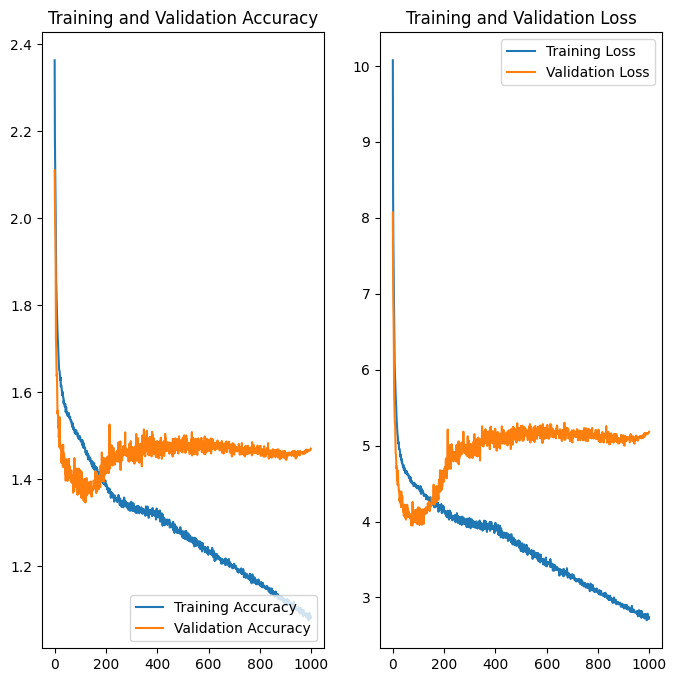

In [30]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [35]:
test_loss, test_acc = model.evaluate(varfval,coefvarfval)

32/32 [==============================] - 0s 3ms/step - loss: 5.1809 - mae: 1.4699


In [33]:
predictions = model.predict(varfval)

32/32 [==============================] - 0s 3ms/step


In [34]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarfval, predictions)

# Calcula la desviación estándar del error
error = coefvarfval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.4699233741194477, Desviación estándar del error: 2.1763655640776474, Error absoluto máximo: 9.876467615365982


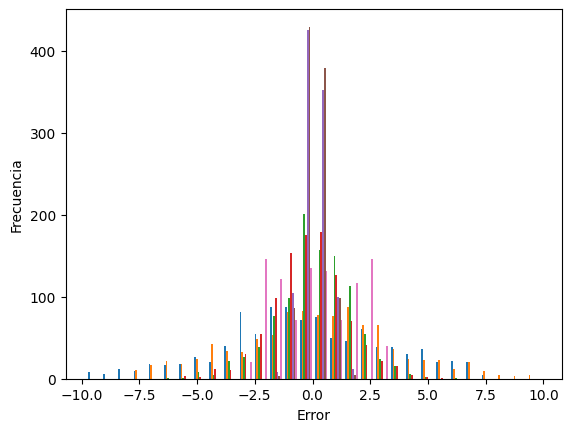

In [36]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [37]:
from sklearn.metrics import r2_score
r2 = r2_score(coefvarfval, predictions)
r2

0.4180818234527005

In [38]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.52801054120064

# Guardamos los datos de Accuracy y Loss

In [39]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 20,50/historyconvtrayec50.csv', index=False)

# Guardamos el modelo

In [40]:
path_to_save = '../../../Modelos con ruido/Modelos 20,50/'

In [41]:
model.save(path_to_save + '/convolucionaltr50.h5')

# Importamos el modelo

In [43]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [56]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 20,50/convolucionaltr50.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [57]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.1
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[5, 2, 7, 8, 6, 2, 1]
(10, 2, 50)


In [58]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [59]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 48ms/step
[[ 3.  3.  7. 10.  6.  2.  2.]]


## Graficamos con los coeficientes reales

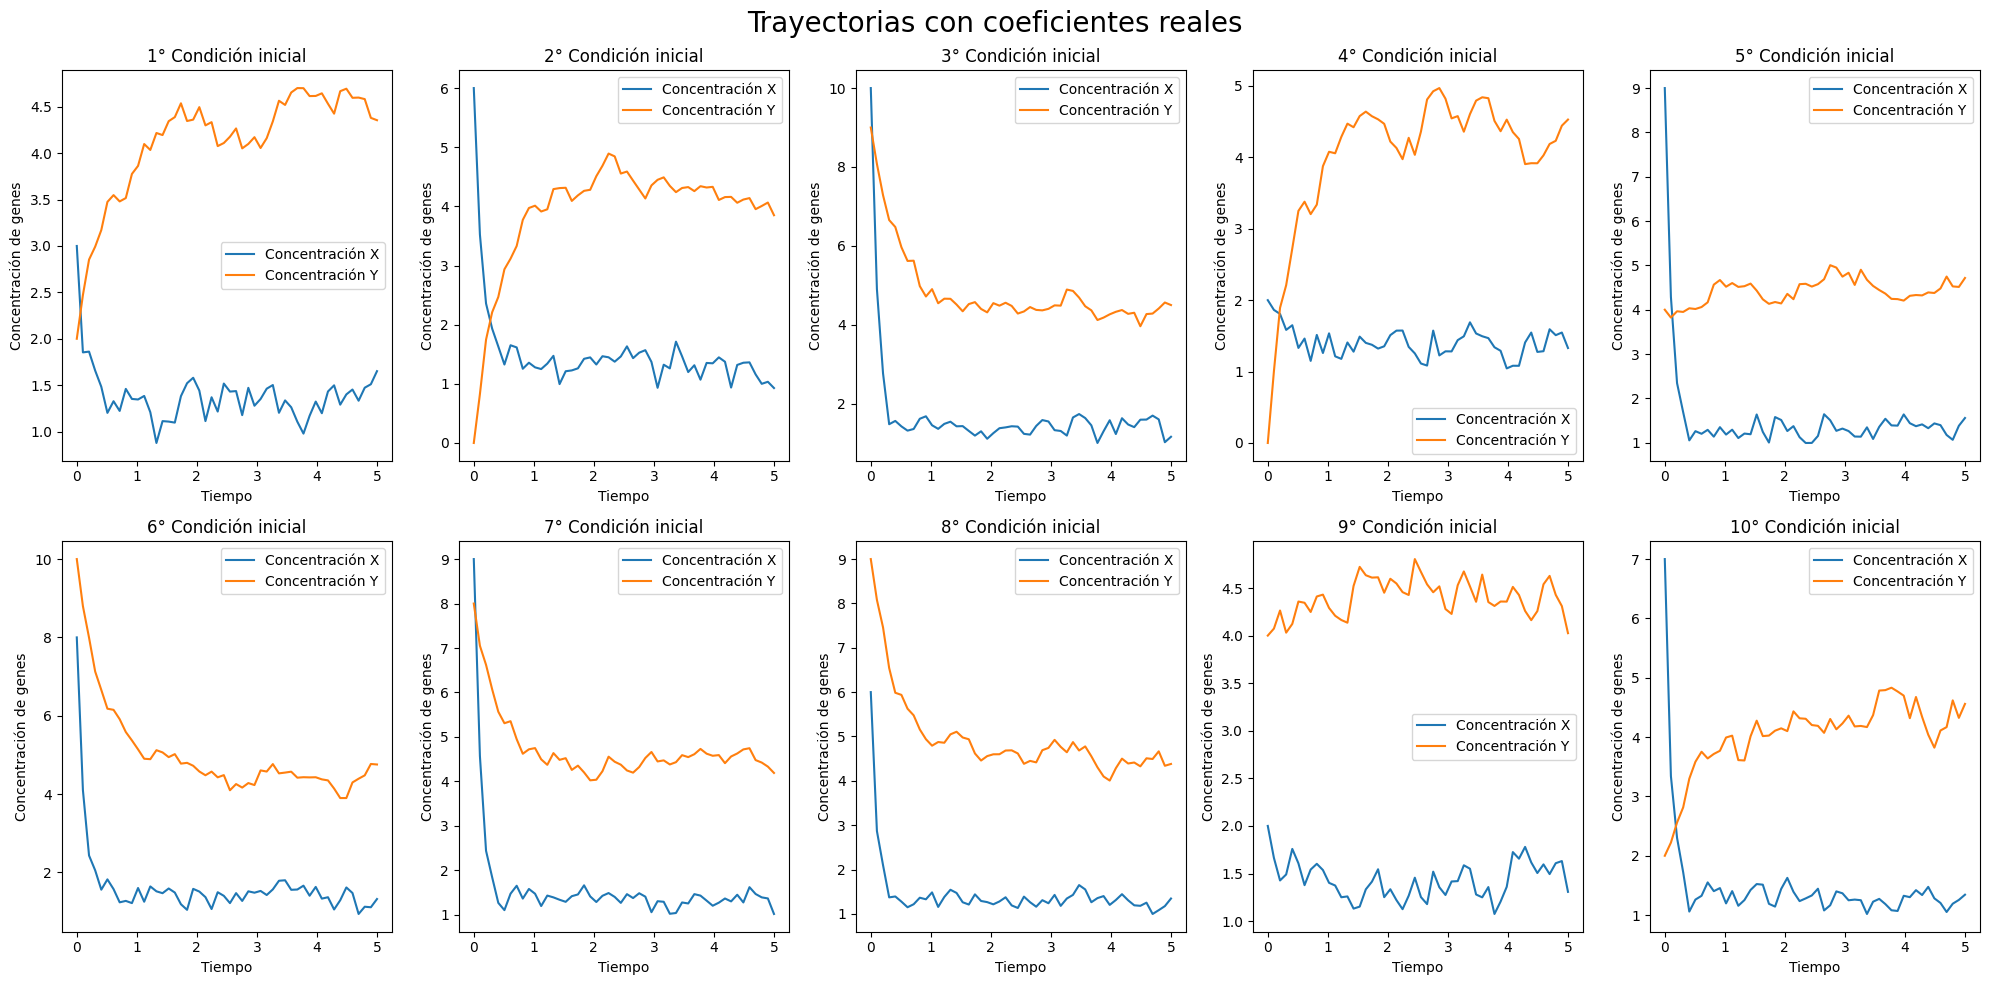

In [60]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [51]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

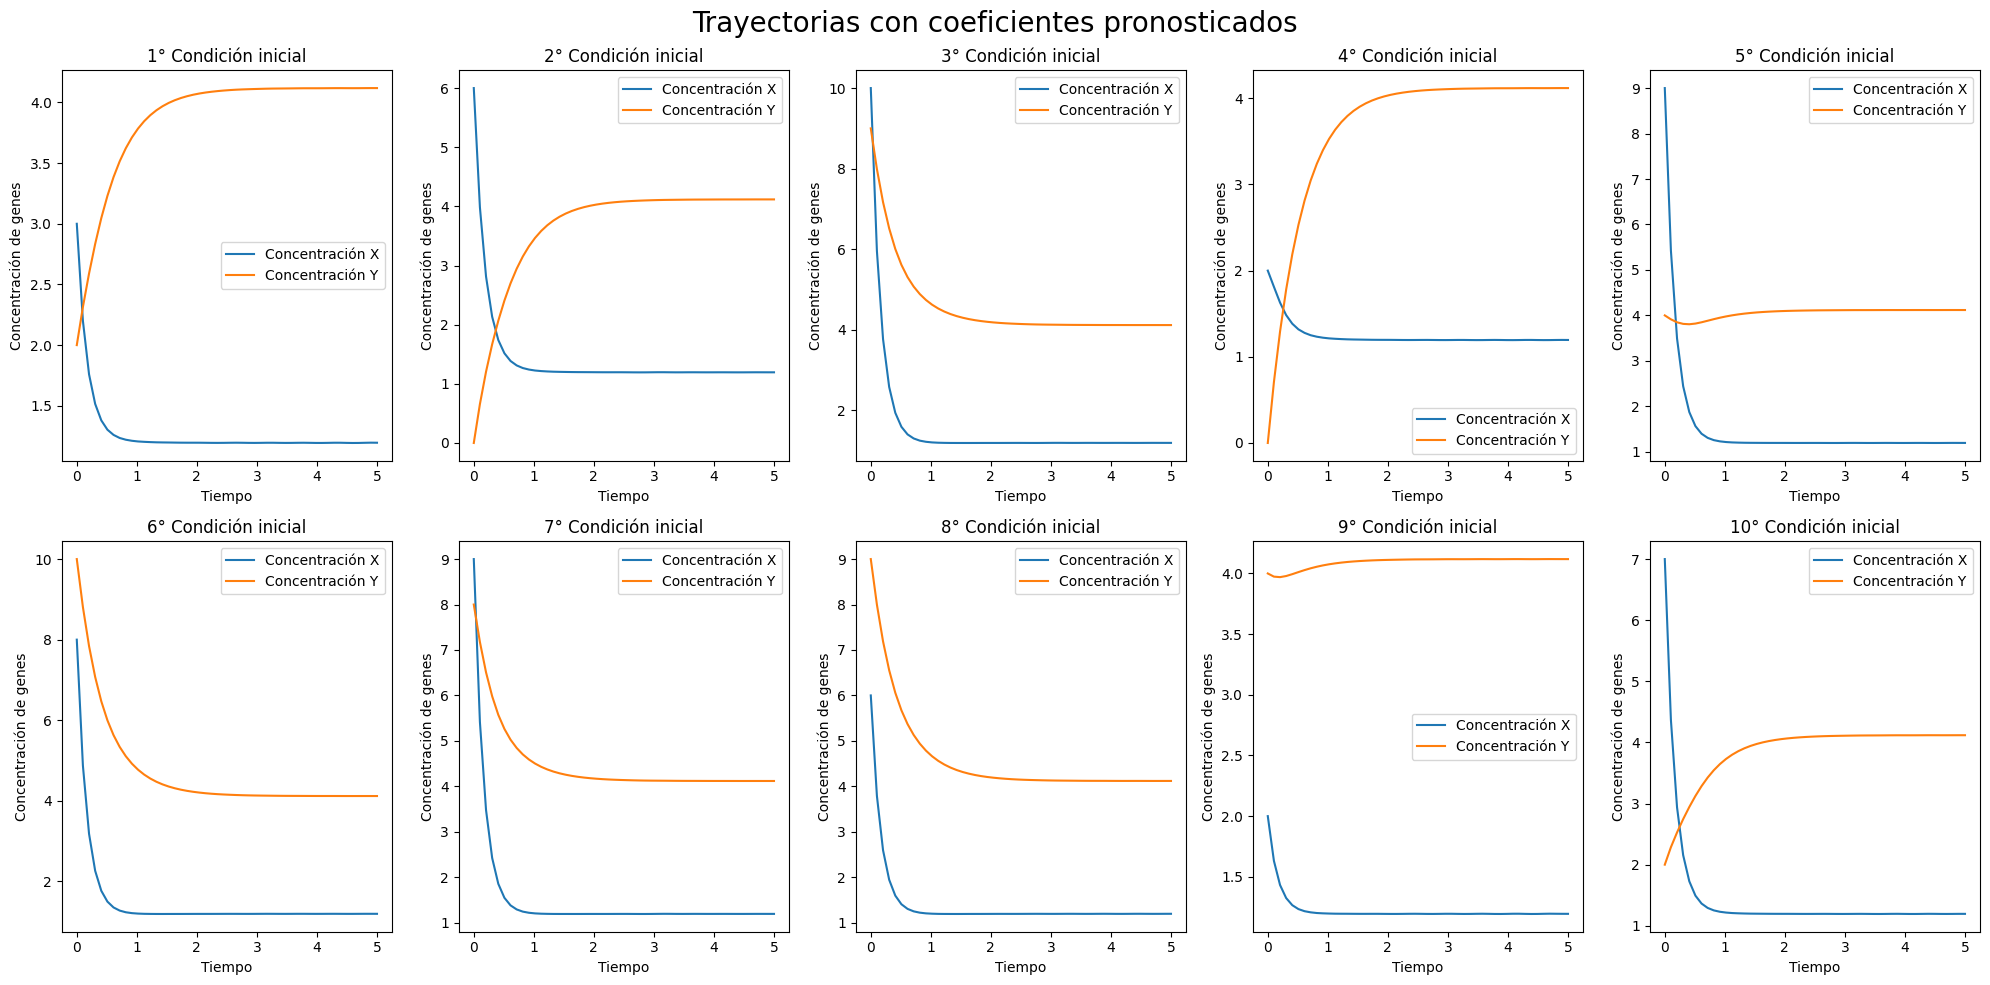

In [61]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

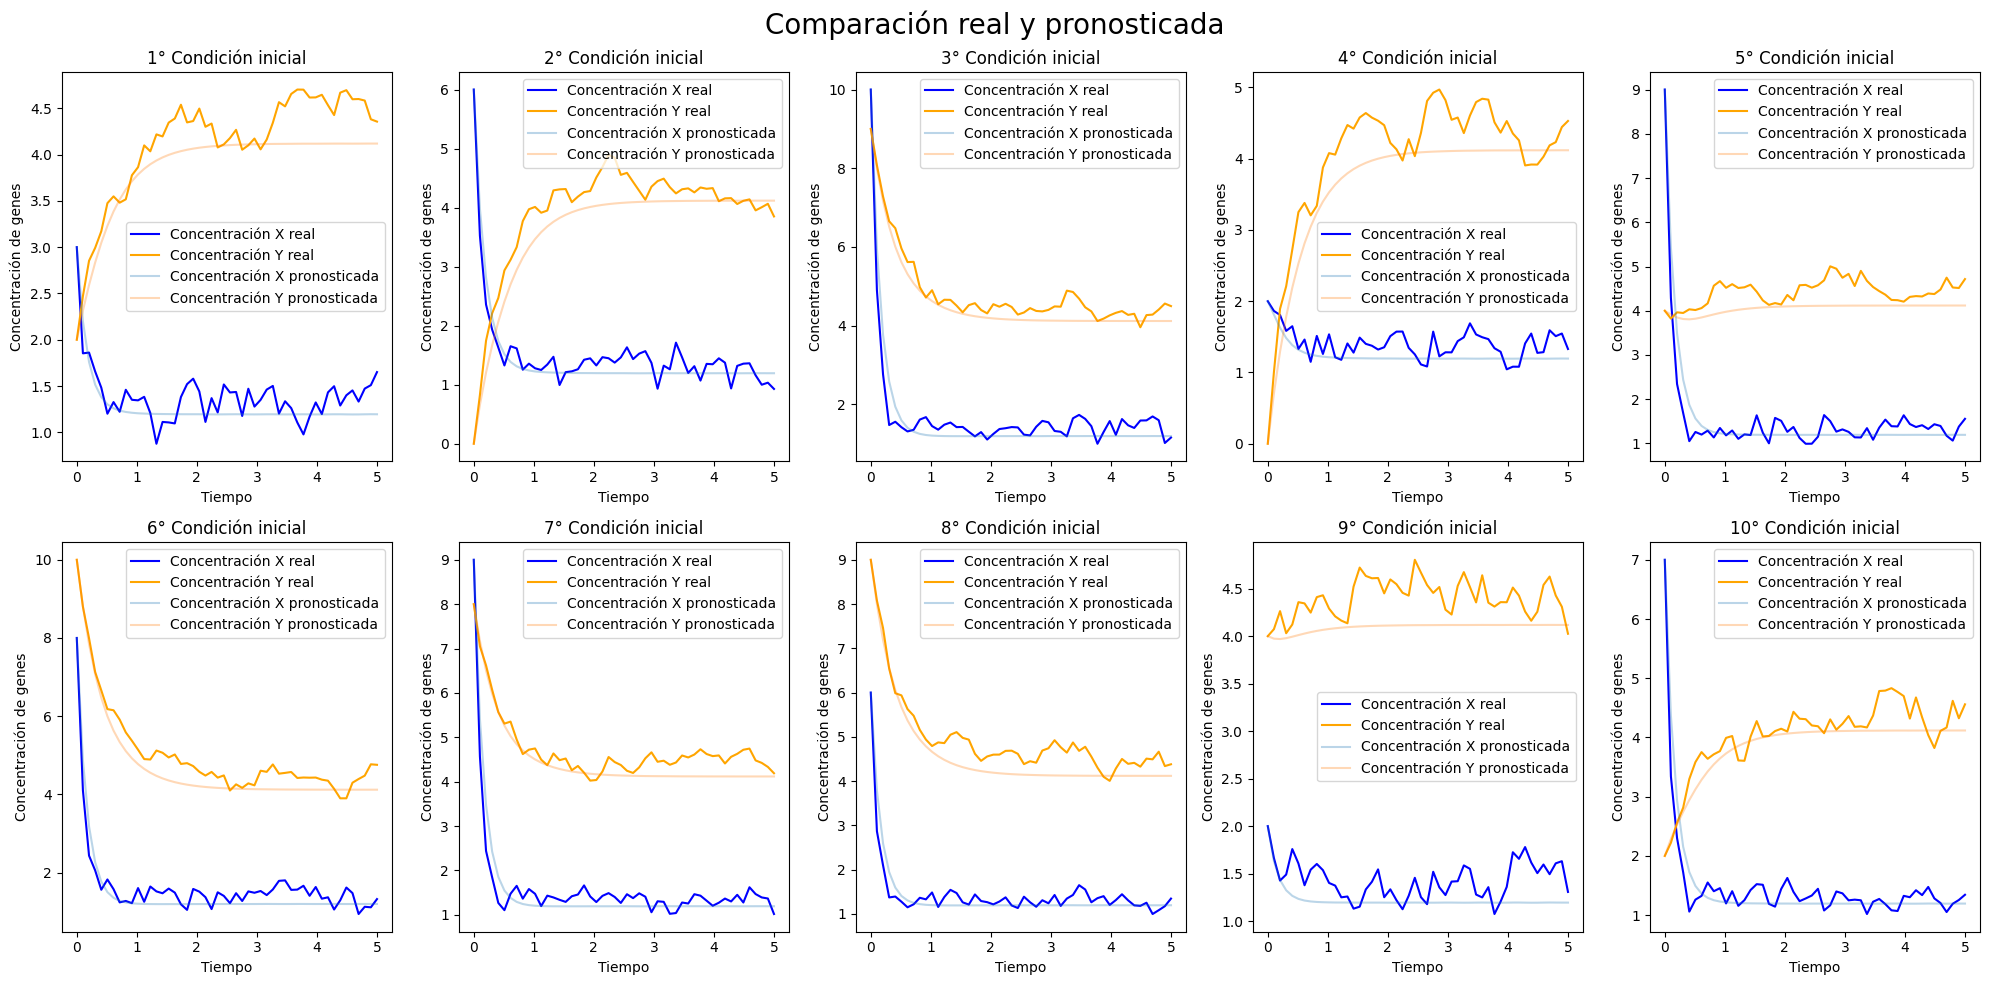

In [63]:
%matplotlib inline
#%matplotlib qt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

# Graficamos las diferencias

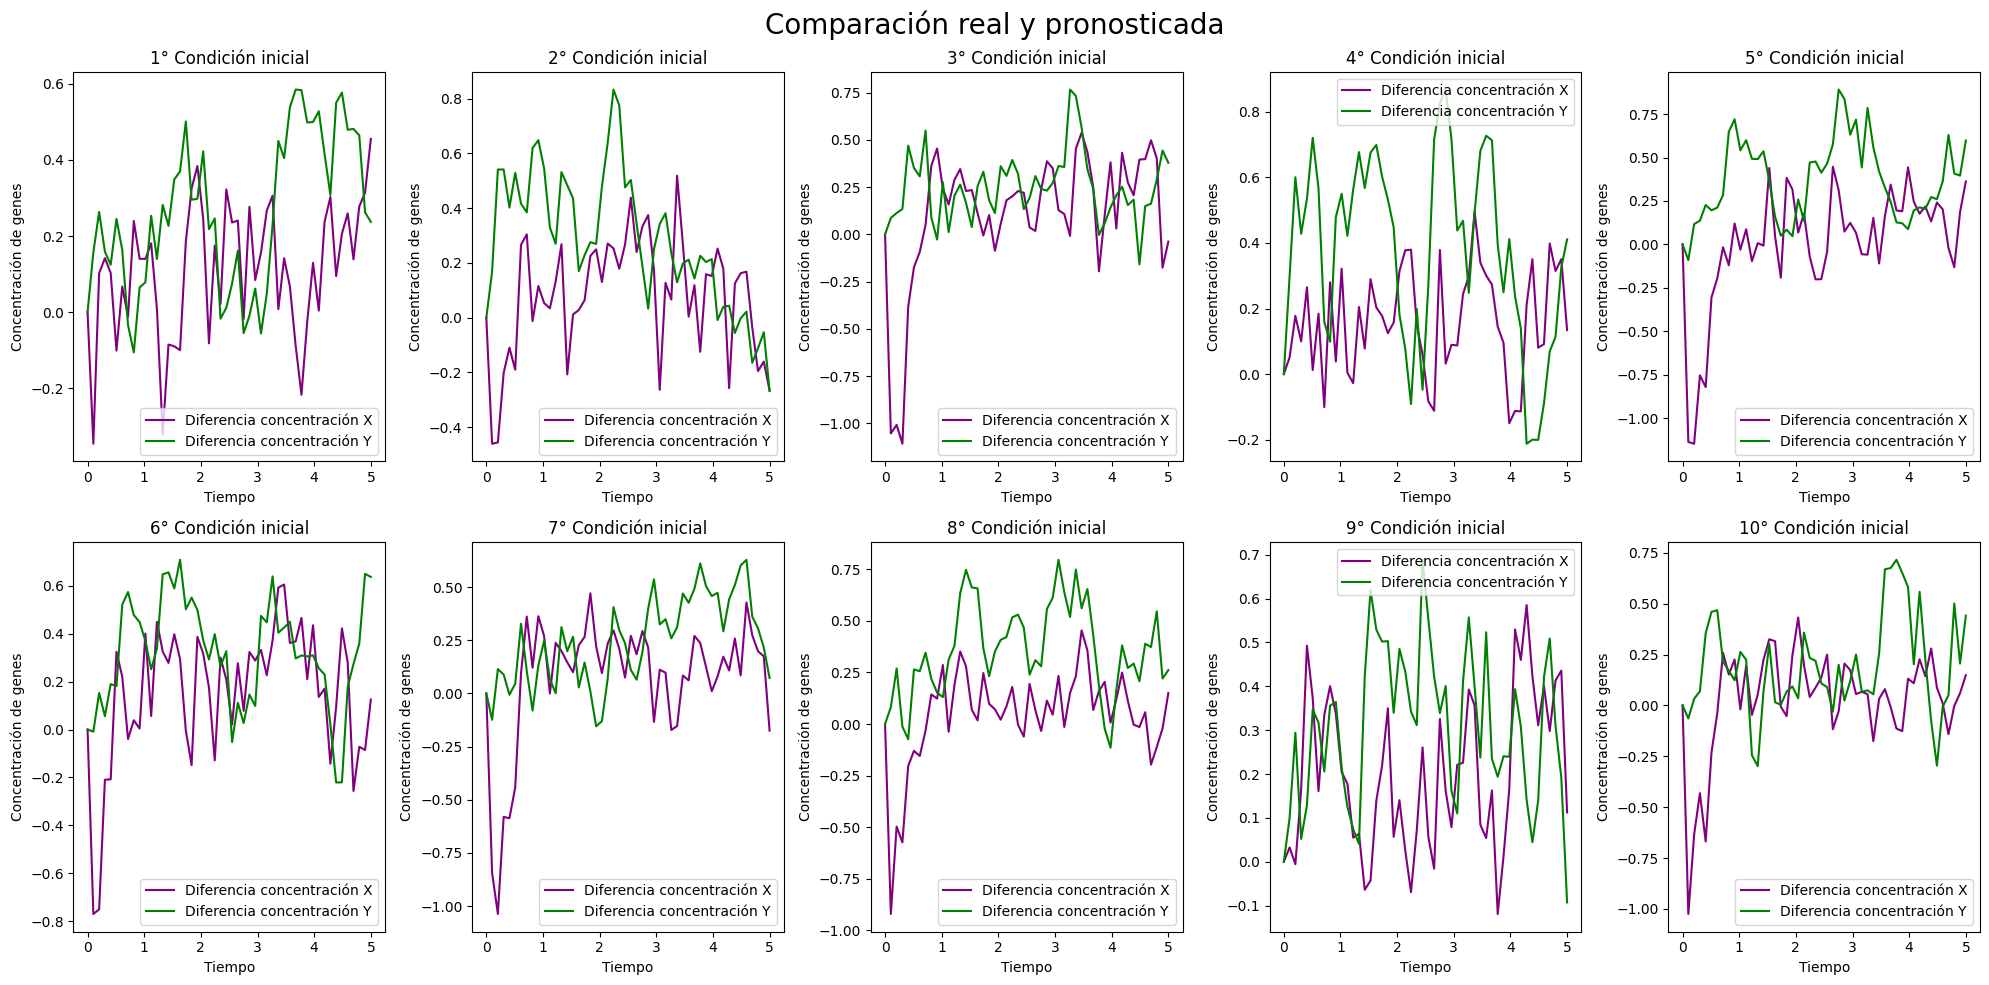

In [64]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [65]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.052840781821124914
0.07784061709861138
